In [1]:
import numpy as np
import pandas as pd
import cv2 as cv 
#from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import os 

import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
train_dir = '/home/wg49/ctmc/data/CTMCCVPR20/train/'
test_dir = '/home/wg49/ctmc/data/CTMCCVPR20/test/'
demo_dir = '/home/wg49/ctmc/data/demo/'
demo_out_dir = '/home/wg49/ctmc/data/demo-out/'
detect_dir = '/home/wg49/ctmc/CTMC-project/yolov5/runs/test/exp4/labels/'

In [3]:
codes = sorted(os.listdir(train_dir))
test_codes = sorted(os.listdir(test_dir))

print("Code", codes)
assert(len(codes) == 47)

# subdir_names = set()
# for code in os.listdir(train_dir):
#   subdir_names |= set(os.listdir(train_dir + code))
# print(subdir_names)

Code ['3T3-run01', '3T3-run03', '3T3-run05', '3T3-run07', '3T3-run09', 'A-10-run01', 'A-10-run03', 'A-10-run05', 'A-10-run07', 'A-549-run03', 'APM-run01', 'APM-run03', 'APM-run05', 'BPAE-run01', 'BPAE-run03', 'BPAE-run05', 'BPAE-run07', 'CRE-BAG2-run01', 'CRE-BAG2-run03', 'CV-1-run01', 'CV-1-run03', 'LLC-MK2-run01', 'LLC-MK2-run02a', 'LLC-MK2-run03', 'LLC-MK2-run05', 'LLC-MK2-run07', 'MDBK-run01', 'MDBK-run03', 'MDBK-run05', 'MDBK-run07', 'MDBK-run09', 'MDOK-run01', 'MDOK-run03', 'MDOK-run05', 'MDOK-run07', 'MDOK-run09', 'OK-run01', 'OK-run03', 'OK-run05', 'OK-run07', 'PL1Ut-run01', 'PL1Ut-run03', 'PL1Ut-run05', 'RK-13-run01', 'RK-13-run03', 'U2O-S-run03', 'U2O-S-run05']


In [16]:
def display_frames(code, frames):
  
  files = ["{}{}/img1/{:06}.jpg".format(train_dir, code, i) for i in frames]
  fig=plt.figure(figsize=(12, 12))
  columns = 4
  rows = 4
  assert (len(files) >= columns * rows )

  for i in range(1, columns * rows + 1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(io.imread( files[i] ))

  plt.show()


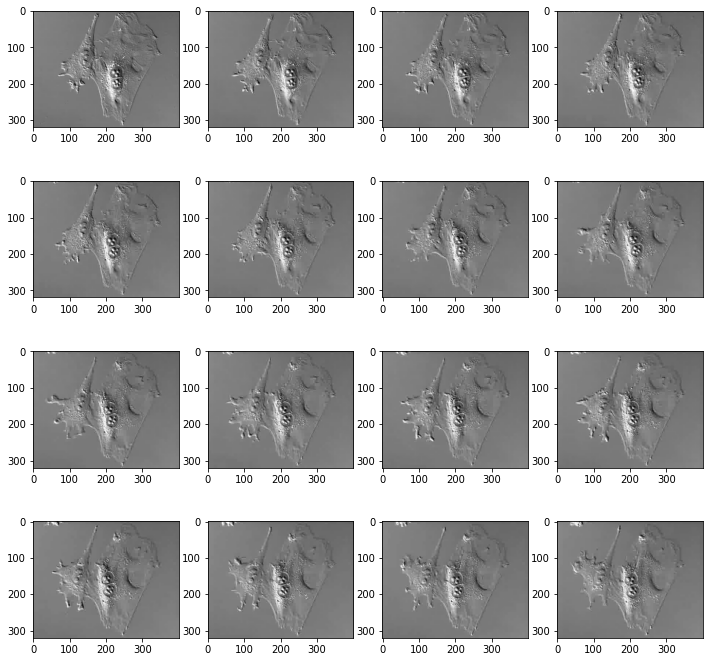

In [17]:
#display_frames('3T3-run01', range(1, 100, 5))

In [ ]:
# How to interpret annotations:
# https://ivc.ischool.utexas.edu/ctmc/
# GT is the bounding boxes (ground truth):
# TRA describes metadata about the cell ids in GT, when they start/end, and what is their parent.
# Download an evaluation script to run and get the MOTA score

1.Download dataset, and get summary data for the dataset: the components of sequences? How many frames?




In [20]:
def get_test_framecount(code):
  return len(os.listdir("{}{}/img1/".format(test_dir, code)))
def get_train_framecount(code):
  return len(os.listdir("{}{}/img1/".format(train_dir, code)))

In [27]:
train_frames = [get_train_framerate(c) for c in codes]
test_frames = [get_test_framerate(c) for c in test_codes]
print(np.array(train_frames).mean())
print(np.array(test_frames).mean())

2.For each video, check the manually labeled output


In [30]:
import pandas as pd

# See https://motchallenge.net/instructions/
# The file format should be the same as the ground truth file, which is a CSV text-file containing one object instance per line. Each line must contain 10 values:

# <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>
# The conf value contains the detection confidence in the det.txt files. 
# For the ground truth, it acts as a flag whether the entry is to be considered. 
# A value of 0 means that this particular instance is ignored in the evaluation, 
# while any other value can be used to mark it as active. 

# For submitted results, all lines in the .txt file are considered. 
# The world coordinates x,y,z are ignored for the 2D challenge and can be filled with -1. 
# Similarly, the bounding boxes are ignored for the 3D challenge. 
# However, each line is still required to contain 10 values.

# All frame numbers, target IDs and bounding boxes are 1-based. 
def get_gt(code):
  return pd.read_csv("{}{}/gt/gt.txt".format(train_dir, code, ), \
                     names=["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"])
def get_tra(code):
  return pd.read_csv("{}{}/TRA/man_track.txt".format(train_dir, code, ), \
                     names=["track_id", "begin_track", "end_track", "parent_track"], \
                     delimiter=" ")
  
def get_detect(code, frame):
  return pd.read_csv("{}/{}-{:06}.txt".format(detect_dir, code, frame), \
                     names=["class", "bb_xcenter", "bb_ycenter", "bb_width", "bb_height", "conf"])
def get_img(code, frame):
   return io.imread("{}{}/img1/{:06}.jpg".format(train_dir, code, frame))

In [ ]:
# 

In [31]:
gt = get_gt("MDOK-run01")
gt.groupby('frame').count()
# [(gt.bb_left[i], gt.bb_top[i], gt.bb_width[i], gt.bb_height[i]) for i in range(len(gt))]

In [37]:
import matplotlib.patches as patches
def display_frames_bound(code, frames):
  
  files = ["{}{}/img1/{:06}.jpg".format(train_dir, code, i) for i in frames]
  gt = get_gt(code)
  rect_list = [(gt.bb_left[i], gt.bb_top[i], gt.bb_width[i], gt.bb_height[i]) for i in frames]
  #print(rect)
  columns,rows = 4,4
  fig, axes =plt.subplots(columns, rows,figsize=(12, 12))
  assert (len(files) >= columns * rows )
  

  for i,ax in enumerate(axes.ravel()):
      im = io.imread( files[i] )
      x,y,w,h, = rect_list[i]
      # print(x,y,w,h)
      # Create a Rectangle patch
      ax.imshow(im)
      # print(im.shape)
      rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

      # Add the patch to the Axes
      ax.add_patch(rect)
      ax.title.set_text("Frame = {}".format(frames[i]))

  fig.suptitle("Frames {}-{} w/ step {} for {}".format(min(frames), frames[i], (frames[i] - min(frames))/i, code), fontsize = 20)
  plt.show()

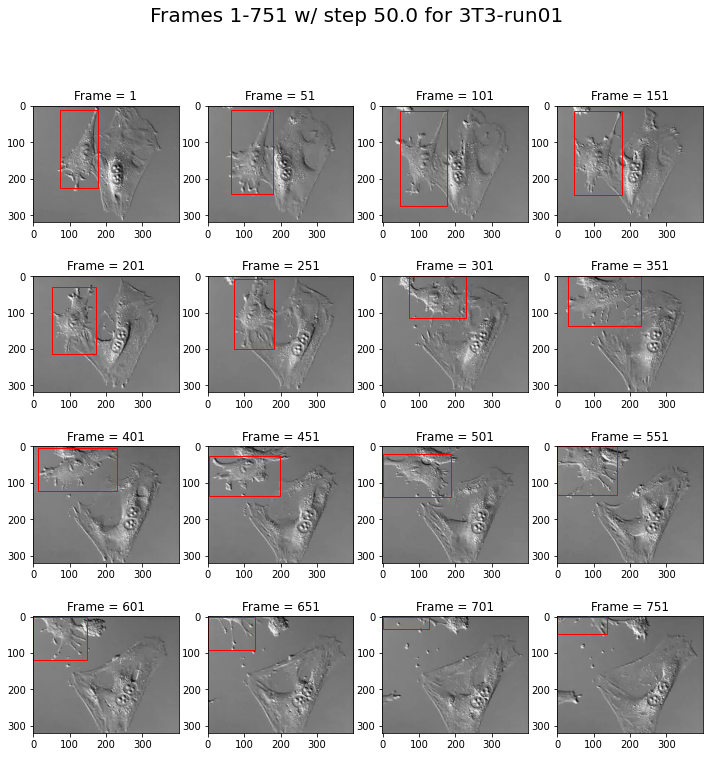

In [39]:
display_frames_bound('3T3-run01', range(1, 1000, 50))

3.Try fitting a very simple OpenCV optical flow model for tracking the cells


In [52]:
# Set up tracker.
# Instead of MIL, you can also use
# pip install opencv-contrib-python
tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
tracker_type = tracker_types[2]

if tracker_type == 'BOOSTING':
    tracker = cv.TrackerBoosting_create()
if tracker_type == 'MIL':
    tracker = cv.TrackerMIL_create()
if tracker_type == 'KCF':
    tracker = cv.TrackerKCF_create()
if tracker_type == 'TLD':
    tracker = cv.TrackerTLD_create()
if tracker_type == 'MEDIANFLOW':
    tracker = cv.TrackerMedianFlow_create()
if tracker_type == 'GOTURN':
    tracker = cv.TrackerGOTURN_create()
if tracker_type == 'MOSSE':
    tracker = cv.TrackerMOSSE_create()
if tracker_type == "CSRT":
    tracker = cv.TrackerCSRT_create()

# Read video
#video = cv2.VideoCapture("videos/chaplin.mp4")
code = '3T3-run01'
gt = get_gt(code)
n_frames = get_train_framerate(code)

gt_bboxes = [(gt.bb_left[i], gt.bb_top[i], gt.bb_width[i], gt.bb_height[i]) for i in range( n_frames)]

bbox = (gt.bb_left[0], gt.bb_top[0], gt.bb_width[0], gt.bb_height[0])
ok = tracker.init(get_img(code, 1),bbox)
# track cell id 1 at frame 1. 

def draw_gt_boxes(frame, frame_num):
  colors = [(0,0,0), (0,255,0), (0,255,255), (255,255,0), (255, 0, 255), (255,100,100), (100, 100, 255)]
  for row in np.array(gt[gt.frame == frame_num]):
    id = row[1]
    bbox = row[2:6]
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv.rectangle(frame, p1, p2, colors[int(id) % len(colors)], 2, 1)

for i in range(2, 1000 + 1): #n_frames + 1):
  frame = get_img(code, i)
  if not ok:
    break
  timer = cv.getTickCount()
  ok, bbox = tracker.update(frame)
  fps = cv.getTickFrequency() / (cv.getTickCount() - timer);
  if ok:
      # Tracking success
      p1 = (int(bbox[0]), int(bbox[1]))
      p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
      cv.rectangle(frame, p1, p2, (255,0,0), 2, 1)
  else:
        # Tracking failure
      cv.putText(frame, "Tracking failure detected", (100,80), cv.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)

  # Display FPS on frame
  # cv.putText(frame, "FPS : " + str(int(fps)), (100,50), cv.FONT_HERSHEY_SIMPLEX, 0.75, (50,170,50), 2);

  if i % 10 == 0:
    # Display result
    # Draw ground truth bounding box

    # Display tracker type on frame
    cv.putText(frame, tracker_type + " Tracker", (100,20), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0),2);

    draw_gt_boxes(frame, i)
    print("Tracking for frame {}".format(i))
    cv2_imshow(frame)
    cv2.imwrite(demo_out_dir + "/{}.png".format(i), frame)


In [48]:
def display_KCF_tracking(code, frames):
  files = [demo_dir + "/{}.png".format(i) for i in frames]
  #gt = get_gt(code)
  #rect_list = [(gt.bb_left[i], gt.bb_top[i], gt.bb_width[i], gt.bb_height[i]) for i in frames]
  #print(rect)
  columns,rows = 4,4
  fig, axes =plt.subplots(columns, rows,figsize=(12, 12))
  #assert (len(files) >= columns * rows )
  

  for i,ax in enumerate(axes.ravel()):
      im = io.imread( files[i] )
      # Create a Rectangle patch
      ax.imshow(im)
      ax.title.set_text("Frame = {}".format(frames[i]))

  fig.suptitle("KCF Tracking for {}".format(code), fontsize = 20)
  plt.show()

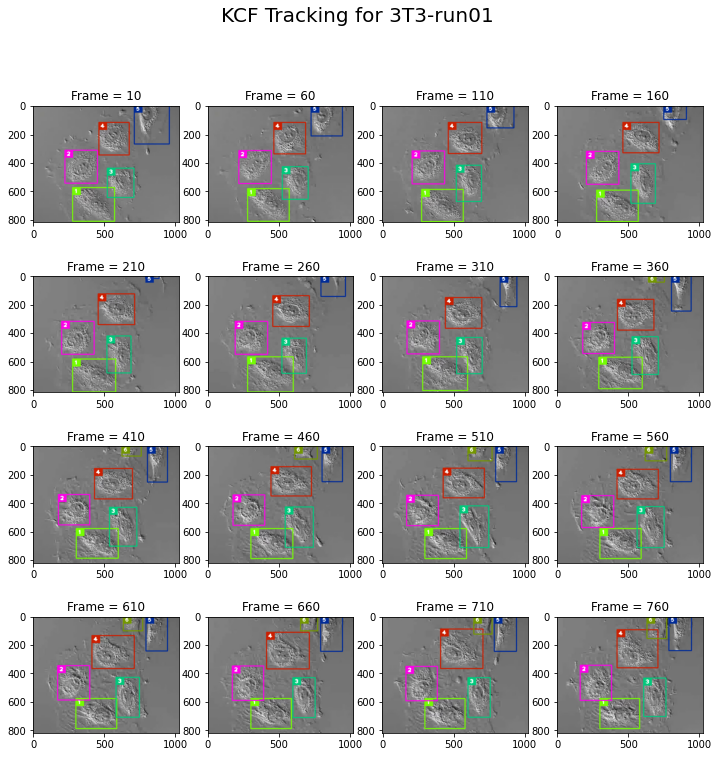

In [50]:
# Script for transforming 
display_KCF_tracking('3T3-run01', range(10, 2000, 50))

In [ ]:
import cv2
import os
code = "3T3-run01"
image_folder = '{}{}/img1/'.format(train_dir, code)
#print(image_folder)
video_name = './data/{}.mp4'.format(code)

images = [img for img in os.listdir(image_folder)]
print(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))
v = cv2.VideoCapture(video_name)
cv2.destroyAllWindows()
video.release()


['001064.jpg', '000643.jpg', '000682.jpg', '000121.jpg', '000763.jpg', '000683.jpg', '000359.jpg', '001311.jpg', '000150.jpg', '000862.jpg', '000344.jpg', '001126.jpg', '001510.jpg', '000216.jpg', '000720.jpg', '000660.jpg', '000280.jpg', '000717.jpg', '000891.jpg', '000028.jpg', '001317.jpg', '000005.jpg', '001651.jpg', '000899.jpg', '000932.jpg', '001475.jpg', '000571.jpg', '000695.jpg', '000754.jpg', '000849.jpg', '000827.jpg', '000487.jpg', '000133.jpg', '001586.jpg', '000206.jpg', '001199.jpg', '000322.jpg', '000249.jpg', '000406.jpg', '001750.jpg', '001376.jpg', '000287.jpg', '000856.jpg', '000015.jpg', '001550.jpg', '000749.jpg', '000308.jpg', '001671.jpg', '001676.jpg', '001423.jpg', '001181.jpg', '001516.jpg', '000580.jpg', '001519.jpg', '001114.jpg', '001212.jpg', '001287.jpg', '001524.jpg', '001328.jpg', '000369.jpg', '000516.jpg', '000104.jpg', '001176.jpg', '001394.jpg', '000756.jpg', '001289.jpg', '001090.jpg', '001264.jpg', '000689.jpg', '000390.jpg', '001094.jpg', '0009

In [ ]:
import matplotlib.patches as patches
def display_detection(seq, frames):
  
  files = ["{}{}/img1/{:06}.jpg".format(train_dir, code, i) for i in frames]
  gt = get_gt(code)
  rect_list = [(gt.bb_left[i], gt.bb_top[i], gt.bb_width[i], gt.bb_height[i]) for i in frames]
  #print(rect)
  columns,rows = 4,4
  fig, axes =plt.subplots(columns, rows,figsize=(12, 12))
  assert (len(files) >= columns * rows )
  

  for i,ax in enumerate(axes.ravel()):
      im = io.imread( files[i] )
      x,y,w,h, = rect_list[i]
      # print(x,y,w,h)
      # Create a Rectangle patch
      ax.imshow(im)
      # print(im.shape)
      rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')

      # Add the patch to the Axes
      ax.add_patch(rect)
      ax.title.set_text("Frame = {}".format(frames[i]))

  fig.suptitle("Frames {}-{} w/ step {} for {}".format(min(frames), frames[i], (frames[i] - min(frames))/i, code), fontsize = 20)
  plt.show()

## Applying DeepSORT

### Installing dependencies

In [66]:
#from deep_sort import *
# !git clone https://github.com/nwojke/deep_sort.git
# !pip install tensorflow==1.15.0 --upgrade
# !pip install scikit-learn==0.22.2 --upgrade
# !pip install motmetrics

In [55]:
import tensorflow as tf

In [58]:
# Step 1.
# Generate detections from standard MOT challenge detections
# resources/detections: result.
! python tools/generate_detections.py \
    --model=resources/networks/mars-small128.pb \
    --mot_dir=../data/CTMCCVPR20/train_small \
    --output_dir=./resources/detections/CTMCCVPR20


2021-04-25 17:20:54.638214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-25 17:20:56.328905: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-25 17:20:56.329092: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: compute-g-16-255.o2.rc.hms.harvard.edu
2021-04-25 17:20:56.329119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: compute-g-16-255.o2.rc.hms.harvard.edu
2021-04-25 17:20:56.334015: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.32.3
2021-04-25 17:20:56.334291: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.32.3
2021-04-25 17:20:56.334395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.32.3
2021-

Frame 00335/01770
Frame 00336/01770
Frame 00337/01770
Frame 00338/01770
Frame 00339/01770
Frame 00340/01770
Frame 00341/01770
Frame 00342/01770
Frame 00343/01770
Frame 00344/01770
Frame 00345/01770
Frame 00346/01770
Frame 00347/01770
Frame 00348/01770
Frame 00349/01770
Frame 00350/01770
Frame 00351/01770
Frame 00352/01770
Frame 00353/01770
Frame 00354/01770
Frame 00355/01770
Frame 00356/01770
Frame 00357/01770
Frame 00358/01770
Frame 00359/01770
Frame 00360/01770
Frame 00361/01770
Frame 00362/01770
Frame 00363/01770
Frame 00364/01770
Frame 00365/01770
Frame 00366/01770
Frame 00367/01770
Frame 00368/01770
Frame 00369/01770
Frame 00370/01770
Frame 00371/01770
Frame 00372/01770
Frame 00373/01770
Frame 00374/01770
Frame 00375/01770
Frame 00376/01770
Frame 00377/01770
Frame 00378/01770
Frame 00379/01770
Frame 00380/01770
Frame 00381/01770
Frame 00382/01770
Frame 00383/01770
Frame 00384/01770
Frame 00385/01770
Frame 00386/01770
Frame 00387/01770
Frame 00388/01770
Frame 00389/01770
Frame 0039

Frame 00791/01770
Frame 00792/01770
Frame 00793/01770
Frame 00794/01770
Frame 00795/01770
Frame 00796/01770
Frame 00797/01770
Frame 00798/01770
Frame 00799/01770
Frame 00800/01770
Frame 00801/01770
Frame 00802/01770
Frame 00803/01770
Frame 00804/01770
Frame 00805/01770
Frame 00806/01770
Frame 00807/01770
Frame 00808/01770
Frame 00809/01770
Frame 00810/01770
Frame 00811/01770
Frame 00812/01770
Frame 00813/01770
Frame 00814/01770
Frame 00815/01770
Frame 00816/01770
Frame 00817/01770
Frame 00818/01770
Frame 00819/01770
Frame 00820/01770
Frame 00821/01770
Frame 00822/01770
Frame 00823/01770
Frame 00824/01770
Frame 00825/01770
Frame 00826/01770
Frame 00827/01770
Frame 00828/01770
Frame 00829/01770
Frame 00830/01770
Frame 00831/01770
Frame 00832/01770
Frame 00833/01770
Frame 00834/01770
Frame 00835/01770
Frame 00836/01770
Frame 00837/01770
Frame 00838/01770
Frame 00839/01770
Frame 00840/01770
Frame 00841/01770
Frame 00842/01770
Frame 00843/01770
Frame 00844/01770
Frame 00845/01770
Frame 0084

Frame 01247/01770
Frame 01248/01770
Frame 01249/01770
Frame 01250/01770
Frame 01251/01770
Frame 01252/01770
Frame 01253/01770
Frame 01254/01770
Frame 01255/01770
Frame 01256/01770
Frame 01257/01770
Frame 01258/01770
Frame 01259/01770
Frame 01260/01770
Frame 01261/01770
Frame 01262/01770
Frame 01263/01770
Frame 01264/01770
Frame 01265/01770
Frame 01266/01770
Frame 01267/01770
Frame 01268/01770
Frame 01269/01770
Frame 01270/01770
Frame 01271/01770
Frame 01272/01770
Frame 01273/01770
Frame 01274/01770
Frame 01275/01770
Frame 01276/01770
Frame 01277/01770
Frame 01278/01770
Frame 01279/01770
Frame 01280/01770
Frame 01281/01770
Frame 01282/01770
Frame 01283/01770
Frame 01284/01770
Frame 01285/01770
Frame 01286/01770
Frame 01287/01770
Frame 01288/01770
Frame 01289/01770
Frame 01290/01770
Frame 01291/01770
Frame 01292/01770
Frame 01293/01770
Frame 01294/01770
Frame 01295/01770
Frame 01296/01770
Frame 01297/01770
Frame 01298/01770
Frame 01299/01770
Frame 01300/01770
Frame 01301/01770
Frame 0130

Frame 01703/01770
Frame 01704/01770
Frame 01705/01770
Frame 01706/01770
Frame 01707/01770
Frame 01708/01770
Frame 01709/01770
Frame 01710/01770
Frame 01711/01770
Frame 01712/01770
Frame 01713/01770
Frame 01714/01770
Frame 01715/01770
Frame 01716/01770
Frame 01717/01770
Frame 01718/01770
Frame 01719/01770
Frame 01720/01770
Frame 01721/01770
Frame 01722/01770
Frame 01723/01770
Frame 01724/01770
Frame 01725/01770
Frame 01726/01770
Frame 01727/01770
Frame 01728/01770
Frame 01729/01770
Frame 01730/01770
Frame 01731/01770
Frame 01732/01770
Frame 01733/01770
Frame 01734/01770
Frame 01735/01770
Frame 01736/01770
Frame 01737/01770
Frame 01738/01770
Frame 01739/01770
Frame 01740/01770
Frame 01741/01770
Frame 01742/01770
Frame 01743/01770
Frame 01744/01770
Frame 01745/01770
Frame 01746/01770
Frame 01747/01770
Frame 01748/01770
Frame 01749/01770
Frame 01750/01770
Frame 01751/01770
Frame 01752/01770
Frame 01753/01770
Frame 01754/01770
Frame 01755/01770
Frame 01756/01770
Frame 01757/01770
Frame 0175

In [61]:
# Step 2.
# Run Tracker on one sequence, given the detection in step 1
# produces tracking result (object and its bounding box at each frame)
! python deep_sort_app.py \
    --sequence_dir=./data/CTMCCVPR20/train/3T3-run05 \
    --detection_file=./resources/detections/CTMCCVPR20/3T3-run05.npy \
    --min_confidence=0.3 \
    --nn_budget=100 \
    --display=True \
    --output_file=./resources/predictions/train/3T3-run05.txt

/home/wg49/jupytervenv/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
processing ../data/CTMCCVPR20/train/3T3-run01
/home/wg49/jupytervenv/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Processing frame 00100
Processing frame 00200
Processing frame 00300
Processing frame 00400
Processing frame 00500
Processing frame 00600
Processing frame 00700
Processing frame 00800
Processing frame 00900
Processing frame 01000
Processing frame 01100
Processing frame 01200
Processing frame 01300
Processing frame 01400
Processing frame 01500
Processing frame 01600
Processing frame 01700


In [112]:
# Run Tracker on one sequence
%%shell
for filename in /content/CTMCCVPR20/train/*; do \
  seq=$(basename $filename); \
  echo "running tracker on $seq"; \
  python deep_sort_app.py \
    --sequence_dir=/content/CTMCCVPR20/train/"$seq" \
    --detection_file=/content/deep_sort/resources/detections/CTMCCVPR20/"$seq".npy \
    --min_confidence=0.3 \
    --nn_budget=100 \
    --display=False \
    --output_file=./resources/predictions/train/"$seq".txt; 
done;


Traceback (most recent call last):
  File "deep_sort_app.py", line 264, in <module>
    args.max_cosine_distance, args.nn_budget, args.display)
  File "deep_sort_app.py", line 207, in run
    visualizer.run(frame_callback)
  File "/content/deep_sort/application_util/visualization.py", line 80, in run
    frame_callback(self, self.frame_idx)
  File "deep_sort_app.py", line 184, in frame_callback
    tracker.update(detections)
  File "/content/deep_sort/deep_sort/tracker.py", line 69, in update
    self._match(detections)
  File "/content/deep_sort/deep_sort/tracker.py", line 127, in _match
    detections, iou_track_candidates, unmatched_detections)
  File "/content/deep_sort/deep_sort/linear_assignment.py", line 58, in min_cost_matching
    indices = linear_assignment(cost_matrix)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py", line 59, in linear_assignment
    indices = _hungarian(X).tolist()
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ut

CalledProcessError: ignored

In [15]:
# Step 3 (optional): for demoing, given result in two, generate a video for each sequence
! python generate_videos.py \
--mot_dir=../CTMCCVPR20/train \
--result_dir=./resources/predictions/train \
--output_dir=./output \

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Saving MDOK-run07.txt to ./output/MDOK-run07.avi.
Frame idx 1
: cannot connect to X server 


In [62]:
# Step 4.
# Evaluate given prediction result in 2 (where?)

! python evaluate_motchallenge.py \
--mot_dir=../CTMCCVPR20/train \
--detection_dir=./resources/detections/CTMCCVPR20 \
--output_dir=./evaluations \

/home/wg49/jupytervenv/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Traceback (most recent call last):
  File "evaluate_motchallenge.py", line 44, in <module>
    sequences = os.listdir(args.mot_dir)
FileNotFoundError: [Errno 2] No such file or directory: '../CTMCCVPR20/train'


In [2]:

# Step 4.
# Copy over ground truth and seqs under test
#rsync ../data/CTMCCVPR20/train/ ./TrackEval/data/gt/mot_challenge/ctmc-train/
#cp seqs_under_test.txt ./TrackEval/data/gt/mot_challenge/seqmaps/ctmc-train.txt

# Copy over prediction and evaluate 
rsync ./resources/predictions/train/ ./TrackEval/data/trackers/mot_challenge/ctmc_train/deepsort/data/
python scripts/run_mot_challenge.py --BENCHMARK ctmc --SPLIT_TO_EVAL train \
  --TRACKERS_TO_EVAL deepsort --DO_PREPROC False

#!/bin/bash
python scripts/run_mot_challenge.py --BENCHMARK ctmc --SPLIT_TO_EVAL train \
  --TRACKERS_TO_EVAL deepsort --DO_PREPROC False
